# Financial Price Prediction with Machine Learning

This project addresses the problem of **predicting the daily price variation for Bitcoin**, using a set of technical and temporal features.  
The variables include indicators such as **RSI and 14-day standard deviation**, as well as the previous day's price and temporal context (month and day of the week)


*(NOTE: the use of a GPU is HIGHLY advised for this notebook, as it uses complex models and algorithms, optimized with these devices)*

We begin the notebook by importing **required libraries**, which will be useful later on the prohect

In [ ]:
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

And we'll fetch data from **Yahoo Finance**, using the *yfinance* library, by defining the ticker (BTC-USD) and time range

In [ ]:
asset = 'BTC-USD'
data = yf.download(asset, start='2015-01-01', end='2025-01-01')
data

/tmp/ipython-input-159-1826343171.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(asset, start='2015-01-01', end='2025-01-01')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,BTC-USD,BTC-USD,BTC-USD,BTC-USD,BTC-USD
Date,,,,,
2015-01-01,314.248993,320.434998,314.002991,320.434998,8036550
2015-01-02,315.032013,315.838989,313.565002,314.079010,7860650
2015-01-03,281.082001,315.149994,281.082001,314.846008,33054400
2015-01-04,264.195007,287.230011,257.612000,281.145996,55629100
2015-01-05,274.473999,278.341003,265.084015,265.084015,43962800
...,...,...,...,...,...
2024-12-27,94164.859375,97294.843750,93310.742188,95704.976562,52419934565
2024-12-28,95163.929688,95525.898438,94014.289062,94160.187500,24107436185


After **downloading** the required data, we'll first check for **N/A values** to avoid future problems over our work

In [ ]:
data.isna().sum()

,,0
Price,Ticker,
Close,BTC-USD,0
High,BTC-USD,0
Low,BTC-USD,0
Open,BTC-USD,0
Volume,BTC-USD,0


Concluded we have **no missing data**, we can start feature engeneering by creating a **clean and usable dataframe**
* We will use Closing price as the **price** to predict, as well as **daily volumes**
* We'll extract **temporal features** through the *"Date"* column
* We'll derive **14-day STD**, as well as **14-day RSI** as techincal features
* We'll adjust **datatypes** for each **feature column**
* And finally, we'll **standardize** the data, while selecting the **correct rows and features**, in order to prepare it for future models



In [ ]:
# CREATE AND START TO FILL DATAFRAME
df = pd.DataFrame([])
df.index = data.index
df["Price"] = data["Close"]
df["Volume"] = data["Volume"]
df = df.reset_index()


### FEATURE ENGENEERING (rounding, mapping and data extracting)
df["Price"] = round(df["Price"], 3)
df["Weekday"] = df["Date"].dt.weekday
df["Day"] = df["Date"].dt.day
df["Month"] = df["Date"].dt.month
df["Year"] = df["Date"].dt.year
df["deltaPrice"] = df["Price"].shift(-1) - df["Price"]


### RSI
gains = np.where(df["deltaPrice"] > 0, df["deltaPrice"], 0) # TOTAL GAINS
losses = np.where(df["deltaPrice"] < 0, -df["deltaPrice"], 0) # TOTAL LOSSES
avg_gain = pd.Series(gains).shift(1).rolling(window=14).mean() # AVERAGE GAIN OVER 14 DAYG
avg_loss = pd.Series(losses).shift(1).rolling(window=14).mean() # AVERAGE LOSS OVER 14 DAYS
rs = avg_gain / avg_loss.replace(0, np.nan) # RS CALCULATION (np.nan to prevent division by 0)
rsi = 100 - (100 / (1 + rs)) # RSI CALCULATION
rsi[avg_loss == 0] = 100 # SPECIAL CASES
rsi[avg_gain == 0] = 0 # SPECIAL CASES
df["RSI_14gg"] = round(rsi, 1)


### STD
df["STD_14gg"] = round(df["Price"].shift(1).rolling(window=14).std(), 2) # CALCULATING STD FOR PRICES IN 14-DAY WINDOW

### DATATYPES
df = df.astype({"Weekday":"int64", "Day":"int64", "Month":"int64", "Year":"int64", "Price":"float64", "deltaPrice":"float64", "RSI_14gg":"float64", "STD_14gg":"float64", "Volume":"int64"})

df = df[14:-1] # SELECT ROWS WITHOUT NaNs (first 14 rows don't have 14-day RSI and STD, so they default to NaN)
df = df[["Weekday", "Day", "Month", "Year", "RSI_14gg", "STD_14gg", "Volume", "deltaPrice"]].reset_index().drop(columns=["index"]) # SELECTING WANTED FEATURES

### STANDARDIZING DATA
scaler = StandardScaler()
scaler.fit(df)
df = pd.DataFrame(scaler.transform(df))
df.columns = ["Weekday", "Day", "Month", "Year", "RSI_14gg", "STD_14gg", "Volume", "deltaPrice"]

df

,Weekday,Day,Month,Year,RSI_14gg,STD_14gg,Volume,deltaPrice
0,-0.000412,-0.086272,-1.612141,-1.576992,-1.371448,-0.757614,-0.937224,-0.028581
1,0.499536,0.027403,-1.612141,-1.576992,-1.398638,-0.756331,-0.939350,-0.035985
2,0.999485,0.141079,-1.612141,-1.576992,-1.224624,-0.756390,-0.940084,-0.015188
3,1.499433,0.254755,-1.612141,-1.576992,-0.898348,-0.754365,-0.939759,-0.022035
4,-1.500258,0.368431,-1.612141,-1.576992,-0.990793,-0.753268,-0.940320,-0.030460
...,...,...,...,...,...,...,...,...
3633,-0.000412,1.164161,1.587674,1.565475,-0.669955,2.264736,1.366939,-1.729524
3634,0.499536,1.277837,1.587674,1.565475,-0.974479,2.406468,1.630104,1.016494
3635,0.999485,1.391512,1.587674,1.565475,-0.843969,2.600420,0.241300,-1.732705
3636,1.499433,1.505188,1.587674,1.565475,-1.344259,2.665906,0.512485,-0.952998


Cleaned and tidied the dataset, we can start defining **input** and **target columns**, differentitating by **discrete** and **continuous numerals** (we'll need that for EDA), since there are **no categorical columns**

In [ ]:
input_cols = ["Weekday", "Day", "Month", "Year", "RSI_14gg", "STD_14gg", "Volume"]
target_col = ["deltaPrice"]

continuous_cols = ["RSI_14gg", "STD_14gg", "Volume"]
discrete_cols = ["Weekday", "Day", "Year"]

Once we finished preparing the data, we can start an **Explorative Data Analysis (EDA)**

By dividing input columns into **categorical**, **discrete numerical**, and **continuous numerical** variables, we can **automatically select** the **most appropriate** visualizations for each type in our **EDA**.

* First, we will conduct a **univariate analysis** of frequencies and *densities* of our **inputs**, checking for relevant outliers and unhomogeneous distributions
* Secondly, every **input feature** will be paired with the **target column** (*deltaPrice*) to **graphically visualize correlations** with price variations
Since **financial markets** are **rarely linearly explainable**, we do not expect clear linear correlations between features and the target
* Lastly, we'll plot **BTC price over the years** to get a grasp of **how this asset evolved over time**

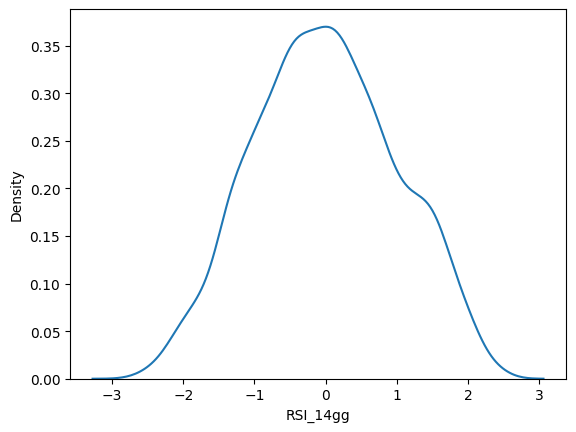

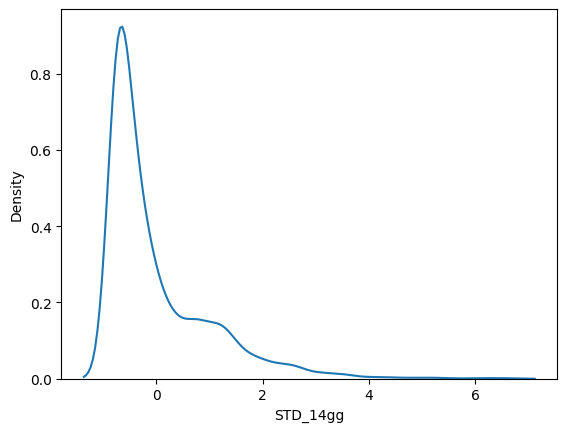

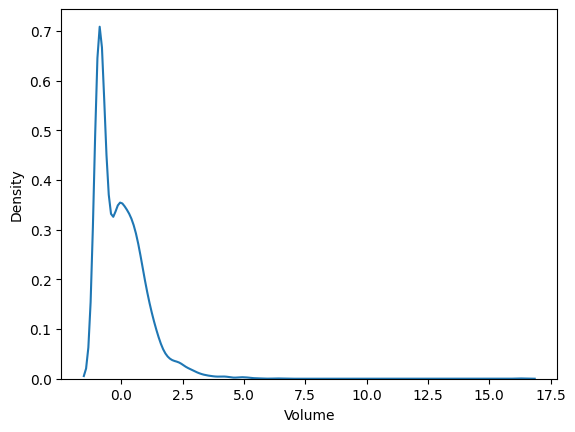

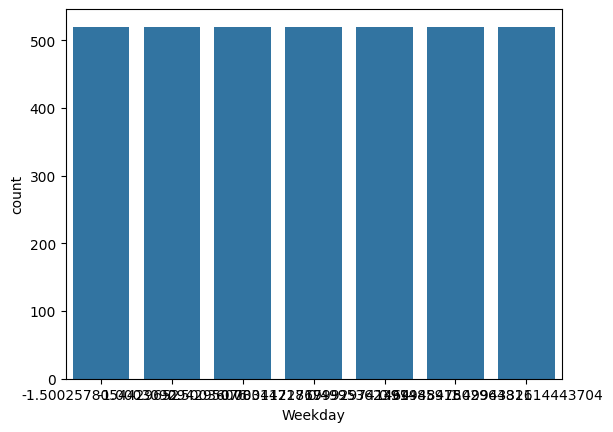

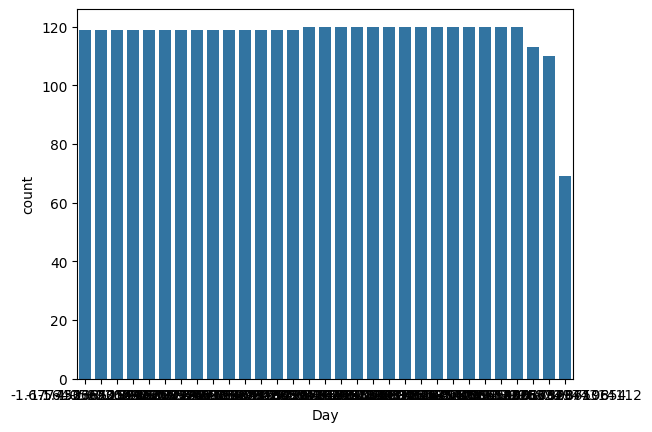

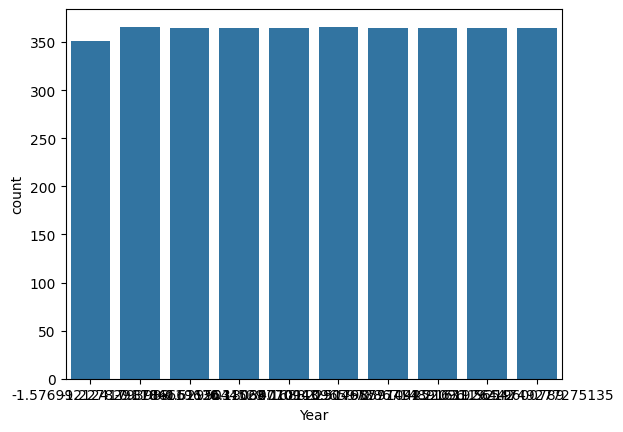

In [ ]:
# UNIVARIATE ANALYSIS
for col in continuous_cols:
  sns.kdeplot(df, x=col)
  plt.show()
for col in discrete_cols:
  sns.countplot(df, x=col)
  plt.show()

**Univariate analysis** showed us **normal distributions** amongst some features (like RSI_14gg and STD_14gg) while others, like **volume**, appear to follow a **bimodal distribution**, potentially due to the large price range that BTC experienced over the last 10 years, resulting in two distinct price eras

Next, we'll conduct **bivariate analysis**, correlating features with the **target column**

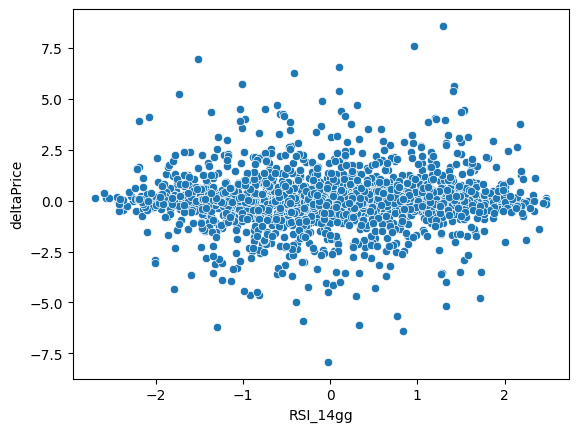

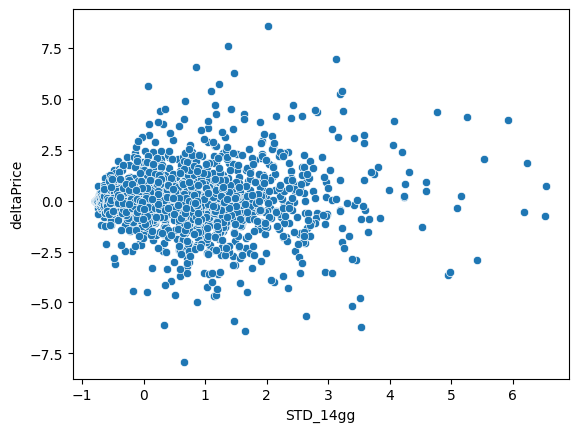

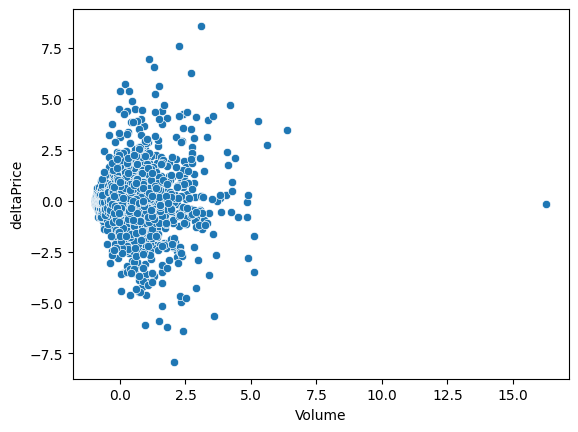

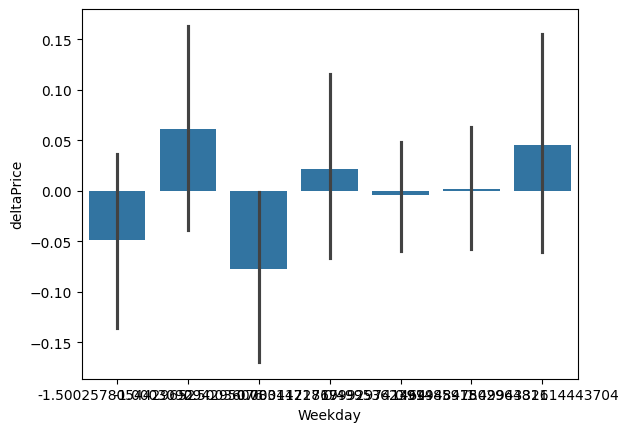

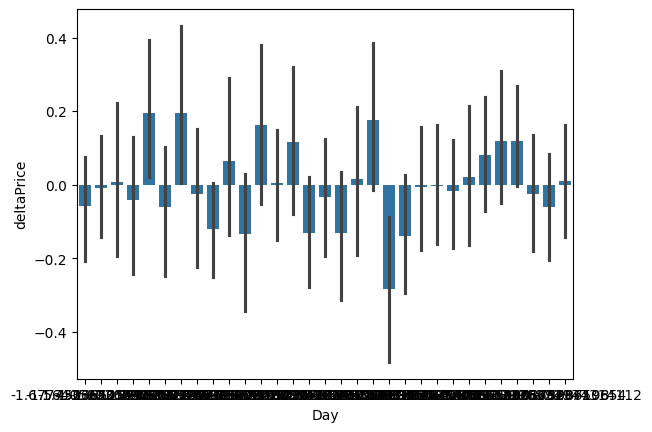

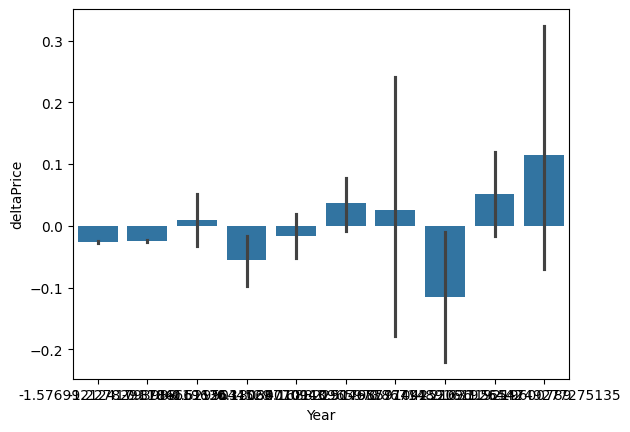

In [ ]:
# BIVARIATE ANALYSIS
for col in continuous_cols:
  sns.scatterplot(df, x=col, y="deltaPrice")
  plt.show()
for col in discrete_cols:
  sns.barplot(df, x=col, y="deltaPrice", estimator="mean")
  plt.show()

For **continuous numerical features** (such as RSI_14gg, STD_14gg, and Volume), the visualizations **do not** reveal any **clear correlation** with the target.

A similar issue can be observed with **discrete numerical features** (such as weekday, day, and month), which also show **high internal variance**, making it difficult to identify consistent patterns.

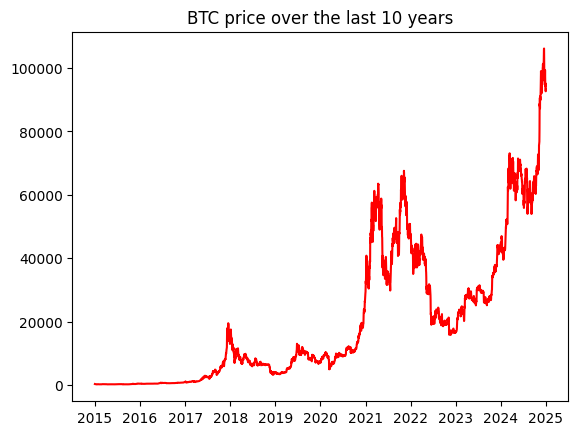

In [ ]:
plt.plot(data.index, data["Close"], color="red")
plt.title("BTC price over the last 10 years")
plt.show()

By **plotting Bitcoin's price**, we can also spot a **possible problem**: prices have an **enormous range**, making it difficult to predict with certainty, but not impossible

By the conducted analysis and results, we decided to try **Neural Network Models** to predict price variations, as they can be **really complex models**, capable of grasping the **subtlest patterns and correlations**, while **not** being **extremely costly** and **time-intensive**

By using **PyTorch** for our project, we **first** need to **initialize torch** and set the **required parameters**, like random seed (42) and device (CUDA if available, else CPU), as well as some variables

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"You are using {device.upper()}")
torch.device(device)

models_losses = []
models_preds = []

You are using CUDA


We decided to create **4 different Neural Networks**, all based on the **Multi-Layer Perceptron (MLP)** architecture, where each neuron is connected to every neuron from the previous layer, for all layers, except for the input

Every one of them will get **7 parameters as inputs** (the selected features) and will produce **one single output** (price variation)
* The **first one (Simple model)** will contain one single hidden layer, consisting of 7 neurons
* The **second one (Moderate model)** will contain two hidden layers, consisting of 32 neurons each
* The **third one (Complex model)** will contain three hidden layers, consisting of 256 neurons each
* And the **last one (Extremly Complex model)** will contain six different hidden layers, consisting of 1024 neurons each

**Loss function** used will be **MSE loss** (so bigger errors will result in much bigger losses)

The chosen **optimizer** is **Adam**, with a fixed **learning rate** of **0.001**

Here's the **first model** being **built**, **trained** for maximum performance and finally **tested**

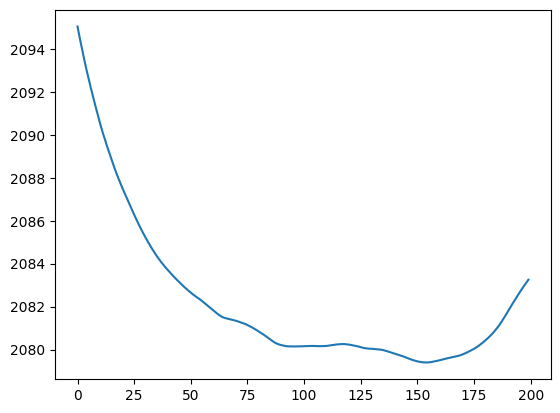

Minimum loss at epoch 154 being 2079.4


In [ ]:
torch.manual_seed(42)

# BUILDING MODEL
class NeuralNetworkModelSimple(torch.nn.Module):
    def __init__(self):
      # 7 INPUT / 7 HIDDEN / 1 OUTPUT
        super().__init__()
        self.hidden1 = torch.nn.Linear(7, 7)
        self.output = torch.nn.Linear(7, 1)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.output(x)
        return x


# TRAIN-TEST SPLIT
train_size = int(len(df) * 0.8)

df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]

train_input = df_train[input_cols]
train_output = df_train[target_col]
test_input = df_test[input_cols]
test_output = df_test[target_col]

train_input_tensor = torch.tensor(train_input.to_numpy(), dtype=torch.float32)
train_output_tensor = torch.tensor(train_output.to_numpy(), dtype=torch.float32)
test_input_tensor = torch.tensor(test_input.to_numpy(), dtype=torch.float32)
test_output_tensor = torch.tensor(test_output.to_numpy(), dtype=torch.float32)

# INITIALIZING MODEL, LOSS FUNCTION AND OPTIMIZER
model = NeuralNetworkModelSimple()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# STANDARDIZATION PARAMETERS
mu_target = scaler.mean_[-1]
sigma_target = scaler.scale_[-1]


### TRAINING
epochs = 200
losses = []
for epoch in range(epochs):

  model.train() # Sets train mode

  y_pred = model(train_input_tensor) # Test model on current params

  loss = loss_fn(train_output_tensor, y_pred) # Calculate loss function

  optimizer.zero_grad() # Resets gradient for the selected optimizer

  loss.backward() # Performs backpropagation

  optimizer.step() # Perform optimization

  model.eval() # Sets evaluation mode (test)

  with torch.inference_mode():
    # Calculate test loss for this epoch
    y_test_pred = model(test_input_tensor)
    loss = loss_fn(test_output_tensor, y_test_pred)
    loss = loss * sigma_target + mu_target
    losses.append(float(loss.detach().numpy()))

# PLOTS LOSSES OVER EVERY EPOCH
plt.plot(range(epochs), losses)
plt.show()

print(f"Minimum loss at epoch {losses.index(min(losses))} being {round(min(losses), 1)}")

We can see that the **minimum loss** *(i.e. maximum performance)* happens at epoch **154**, so we'll **retrain** it stopping at **154 loops**

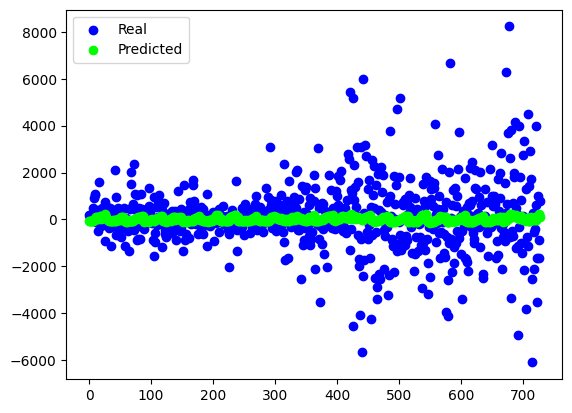

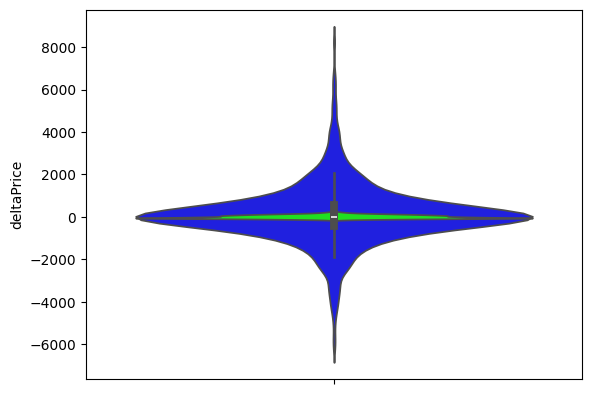

In [ ]:
torch.manual_seed(42)

# BUILDING MODEL
class NeuralNetworkModelSimple(torch.nn.Module):
    def __init__(self):
      # 7 INPUT / 7 HIDDEN / 1 OUTPUT
        super().__init__()
        self.hidden1 = torch.nn.Linear(7, 7)
        self.output = torch.nn.Linear(7, 1)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.output(x)
        return x


# TRAIN-TEST SPLIT
train_size = int(len(df) * 0.8)

df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]

train_input = df_train[input_cols]
train_output = df_train[target_col]
test_input = df_test[input_cols]
test_output = df_test[target_col]

train_input_tensor = torch.tensor(train_input.to_numpy(), dtype=torch.float32)
train_output_tensor = torch.tensor(train_output.to_numpy(), dtype=torch.float32)
test_input_tensor = torch.tensor(test_input.to_numpy(), dtype=torch.float32)
test_output_tensor = torch.tensor(test_output.to_numpy(), dtype=torch.float32)

# INITIALIZING MODEL, LOSS FUNCTION AND OPTIMIZER
model = NeuralNetworkModelSimple()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# STANDARDIZATION PARAMETERS
mu_target = scaler.mean_[-1]
sigma_target = scaler.scale_[-1]


### TRAINING
epochs = losses.index(min(losses))+1
for epoch in range(epochs):

  model.train() # Sets train mode

  y_pred = model(train_input_tensor) # Test model on current params

  loss = loss_fn(train_output_tensor, y_pred) # Calculate loss function

  optimizer.zero_grad() # Resets gradient for the selected optimizer

  loss.backward() # Performs backpropagation

  optimizer.step() # Perform optimization

  model.eval() # Sets evaluation mode (test)


# FINAL TESTING
y_pred_tens = model(test_input_tensor)
y_pred = y_pred_tens.detach().numpy()

# RE-CONVERTING FROM STANDARDIZED OUTPUTS
test_output = test_output * sigma_target + mu_target
y_pred = y_pred * sigma_target + mu_target

# CALCULATE LOSS
loss = loss_fn(test_output_tensor, y_pred_tens)
plt.scatter(range(len(test_output)), test_output, color="blue", label="Real")
plt.scatter(range(len(y_pred)), y_pred, color="#00FF00", label="Predicted")
plt.legend()
plt.show()

# SHOW PREDICTION DENSITIES
sns.violinplot(test_output.squeeze(), fill=True, color="blue", label="Real")
sns.violinplot(y_pred.squeeze(), fill=True, color="#00FF00", label="Predicted")
plt.show()

models_losses.append(float(loss.detach().numpy())* sigma_target + mu_target)
models_preds.append(y_pred.squeeze())

From this **first simple model** we can see how its **prediction range** is really **small** compared to the actual deltaPrice range, suggesting how it might **not** be able to **capture all patterns**, while using a **conservative** approach by predicting **close to the mean**

We can then try **training** a slightly more **complex model**, in hopes of catching more **underlying correlations** between the data

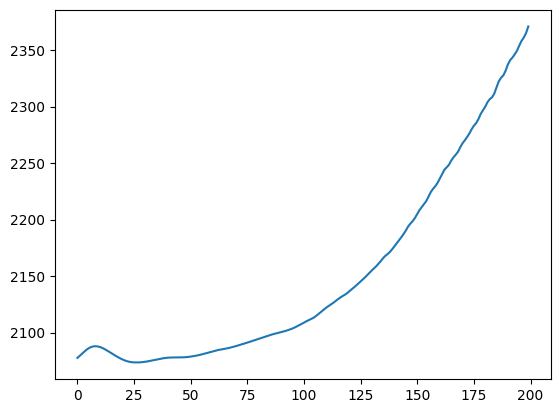

Minimum loss at epoch 26 being 2073.5


In [ ]:
torch.manual_seed(42)

# BUILDING MODEL
class NeuralNetworkModelMedium(torch.nn.Module):
    def __init__(self):
      # 7 INPUT / 2x32 HIDDEN / 1 OUTPUT
        super().__init__()
        self.hidden1 = torch.nn.Linear(7, 32)
        self.hidden2 = torch.nn.Linear(32, 32)
        self.output = torch.nn.Linear(32, 1)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.output(x)
        return x


# TRAIN-TEST SPLIT
train_size = int(len(df) * 0.8)

df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]

train_input = df_train[input_cols]
train_output = df_train[target_col]
test_input = df_test[input_cols]
test_output = df_test[target_col]

train_input_tensor = torch.tensor(train_input.to_numpy(), dtype=torch.float32)
train_output_tensor = torch.tensor(train_output.to_numpy(), dtype=torch.float32)
test_input_tensor = torch.tensor(test_input.to_numpy(), dtype=torch.float32)
test_output_tensor = torch.tensor(test_output.to_numpy(), dtype=torch.float32)

# INITIALIZING MODEL, LOSS FUNCTION AND OPTIMIZER
model = NeuralNetworkModelMedium()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# STANDARDIZATION PARAMETERS
mu_target = scaler.mean_[-1]
sigma_target = scaler.scale_[-1]


### TRAINING
epochs = 200
losses = []
for epoch in range(epochs):

  model.train() # Sets train mode

  y_pred = model(train_input_tensor) # Test model on current params

  loss = loss_fn(train_output_tensor, y_pred) # Calculate loss function

  optimizer.zero_grad() # Resets gradient for the selected optimizer

  loss.backward() # Performs backpropagation

  optimizer.step() # Perform optimization

  model.eval() # Sets evaluation mode (test)

  with torch.inference_mode():
    # Calculate test loss for this epoch
    y_test_pred = model(test_input_tensor)
    loss = loss_fn(test_output_tensor, y_test_pred)
    loss = loss * sigma_target + mu_target
    losses.append(float(loss.detach().numpy()))

# PLOTS LOSSES OVER EVERY EPOCH
plt.plot(range(epochs), losses)
plt.show()

print(f"Minimum loss at epoch {losses.index(min(losses))} being {round(min(losses), 1)}")

As we'd done before, we can see how the **best performances** had been given with **26 epochs** of training. So, we'll **retrain** the model, and show the **predictions**

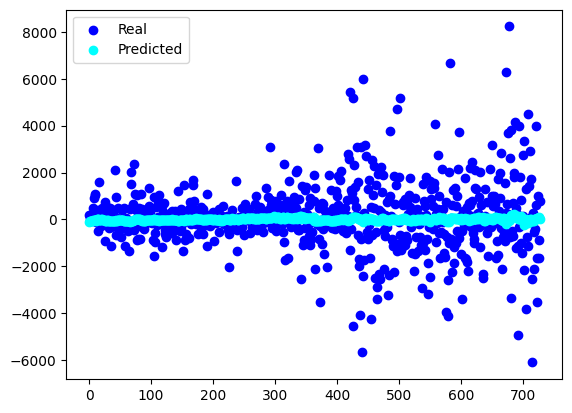

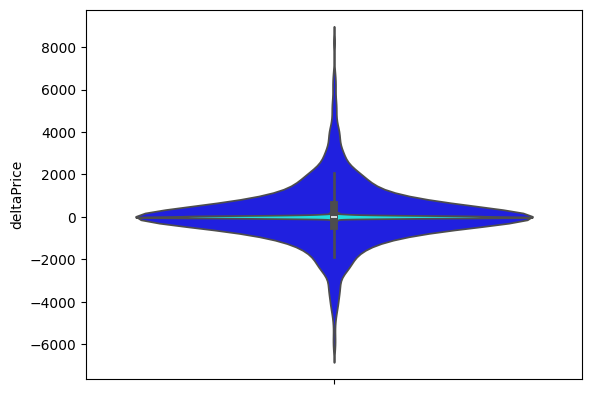

In [ ]:
torch.manual_seed(42)

# BUILDING MODEL
class NeuralNetworkModelMedium(torch.nn.Module):
    def __init__(self):
      # 7 INPUT / 2x32 HIDDEN / 1 OUTPUT
        super().__init__()
        self.hidden1 = torch.nn.Linear(7, 32)
        self.hidden2 = torch.nn.Linear(32, 32)
        self.output = torch.nn.Linear(32, 1)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.output(x)
        return x


# TRAIN-TEST SPLIT
train_size = int(len(df) * 0.8)

df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]

train_input = df_train[input_cols]
train_output = df_train[target_col]
test_input = df_test[input_cols]
test_output = df_test[target_col]

train_input_tensor = torch.tensor(train_input.to_numpy(), dtype=torch.float32)
train_output_tensor = torch.tensor(train_output.to_numpy(), dtype=torch.float32)
test_input_tensor = torch.tensor(test_input.to_numpy(), dtype=torch.float32)
test_output_tensor = torch.tensor(test_output.to_numpy(), dtype=torch.float32)

# INITIALIZING MODEL, LOSS FUNCTION AND OPTIMIZER
model = NeuralNetworkModelMedium()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# STANDARDIZATION PARAMETERS
mu_target = scaler.mean_[-1]
sigma_target = scaler.scale_[-1]


### TRAINING
epochs = losses.index(min(losses))+1
for epoch in range(epochs):

  model.train() # Sets train mode

  y_pred = model(train_input_tensor) # Test model on current params

  loss = loss_fn(train_output_tensor, y_pred) # Calculate loss function

  optimizer.zero_grad() # Resets gradient for the selected optimizer

  loss.backward() # Performs backpropagation

  optimizer.step() # Perform optimization

  model.eval() # Sets evaluation mode (test)


# FINAL TESTING
y_pred_tens = model(test_input_tensor)
y_pred = y_pred_tens.detach().numpy()

# RE-CONVERTING FROM STANDARDIZED OUTPUTS
test_output = test_output * sigma_target + mu_target
y_pred = y_pred * sigma_target + mu_target

# CALCULATE LOSS
loss = loss_fn(test_output_tensor, y_pred_tens)
plt.scatter(range(len(test_output)), test_output, color="blue", label="Real")
plt.scatter(range(len(y_pred)), y_pred, color="#00FFFF", label="Predicted")
plt.legend()
plt.show()

# SHOW PREDICTION DENSITIES
import matplotlib
sns.violinplot(test_output.squeeze(), fill=True, color="blue", label="Real")
sns.violinplot(y_pred.squeeze(), fill=True, color="#00FFFF", label="Predicted")
plt.show()

models_losses.append(float(loss.detach().numpy())* sigma_target + mu_target)
models_preds.append(y_pred.squeeze())

Similar to before, the model decided to take a more **conservative strategy**, predicting **close** to the **mean**, while lowering the loss by some points
We can try **training** a more **complex model** to see wether this trend will continue, or we just need a **better more complex model**

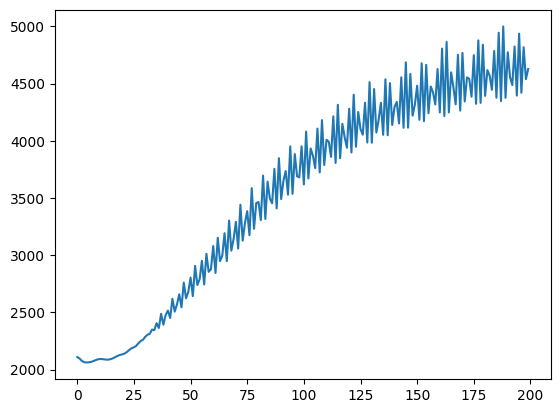

Minimum loss at epoch 4 being 2061.8


In [ ]:
torch.manual_seed(42)

# BUILDING MODEL
class NeuralNetworkModelComplex(torch.nn.Module):
    def __init__(self):
      # 7 INPUT / 3x256 HIDDEN / 1 OUTPUT
        super().__init__()
        self.hidden1 = torch.nn.Linear(7, 256)
        self.hidden2 = torch.nn.Linear(256, 256)
        self.hidden3 = torch.nn.Linear(256, 256)
        self.output = torch.nn.Linear(256, 1)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.relu(self.hidden3(x))
        x = self.output(x)
        return x


# TRAIN-TEST SPLIT
train_size = int(len(df) * 0.8)

df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]

train_input = df_train[input_cols]
train_output = df_train[target_col]
test_input = df_test[input_cols]
test_output = df_test[target_col]

train_input_tensor = torch.tensor(train_input.to_numpy(), dtype=torch.float32)
train_output_tensor = torch.tensor(train_output.to_numpy(), dtype=torch.float32)
test_input_tensor = torch.tensor(test_input.to_numpy(), dtype=torch.float32)
test_output_tensor = torch.tensor(test_output.to_numpy(), dtype=torch.float32)

# INITIALIZING MODEL, LOSS FUNCTION AND OPTIMIZER
model = NeuralNetworkModelComplex()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# STANDARDIZATION PARAMETERS
mu_target = scaler.mean_[-1]
sigma_target = scaler.scale_[-1]


### TRAINING
epochs = 200
losses = []
for epoch in range(epochs):

  model.train() # Sets train mode

  y_pred = model(train_input_tensor) # Test model on current params

  loss = loss_fn(train_output_tensor, y_pred) # Calculate loss function

  optimizer.zero_grad() # Resets gradient for the selected optimizer

  loss.backward() # Performs backpropagation

  optimizer.step() # Perform optimization

  model.eval() # Sets evaluation mode (test)

  with torch.inference_mode():
    # Calculate test loss for this epoch
    y_test_pred = model(test_input_tensor)
    loss = loss_fn(test_output_tensor, y_test_pred)
    loss = loss * sigma_target + mu_target
    losses.append(float(loss.detach().numpy()))

# PLOTS LOSSES OVER EVERY EPOCH
plt.plot(range(epochs), losses)
plt.show()

print(f"Minimum loss at epoch {losses.index(min(losses))} being {round(min(losses), 1)}")

This time, the model reached **minimum loss sooner**, possibly indicating a **more overfitting model** than the previous ones. We can then train the same model with only **4 epochs**, seeing how it performs

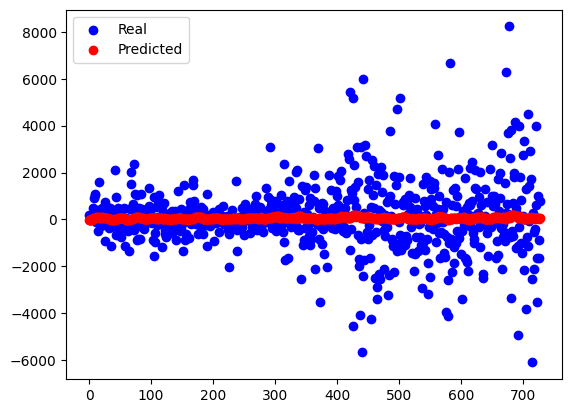

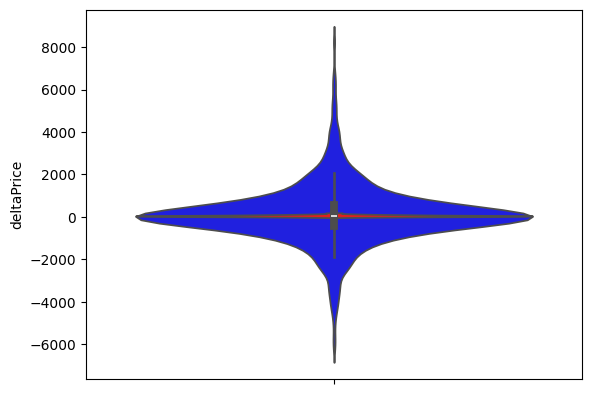

In [ ]:
torch.manual_seed(42)

# BUILDING MODEL
class NeuralNetworkModelComplex(torch.nn.Module):
    def __init__(self):
      # 7 INPUT / 3x256 HIDDEN / 1 OUTPUT
        super().__init__()
        self.hidden1 = torch.nn.Linear(7, 256)
        self.hidden2 = torch.nn.Linear(256, 256)
        self.hidden3 = torch.nn.Linear(256, 256)
        self.output = torch.nn.Linear(256, 1)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.relu(self.hidden3(x))
        x = self.output(x)
        return x


# TRAIN-TEST SPLIT
train_size = int(len(df) * 0.8)

df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]

train_input = df_train[input_cols]
train_output = df_train[target_col]
test_input = df_test[input_cols]
test_output = df_test[target_col]

train_input_tensor = torch.tensor(train_input.to_numpy(), dtype=torch.float32)
train_output_tensor = torch.tensor(train_output.to_numpy(), dtype=torch.float32)
test_input_tensor = torch.tensor(test_input.to_numpy(), dtype=torch.float32)
test_output_tensor = torch.tensor(test_output.to_numpy(), dtype=torch.float32)

# INITIALIZING MODEL, LOSS FUNCTION AND OPTIMIZER
model = NeuralNetworkModelComplex()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# STANDARDIZATION PARAMETERS
mu_target = scaler.mean_[-1]
sigma_target = scaler.scale_[-1]


### TRAINING
epochs = losses.index(min(losses))+1
for epoch in range(epochs):

  model.train() # Sets train mode

  y_pred = model(train_input_tensor) # Test model on current params

  loss = loss_fn(train_output_tensor, y_pred) # Calculate loss function

  optimizer.zero_grad() # Resets gradient for the selected optimizer

  loss.backward() # Performs backpropagation

  optimizer.step() # Perform optimization

  model.eval() # Sets evaluation mode (test)


# FINAL TESTING
y_pred_tens = model(test_input_tensor)
y_pred = y_pred_tens.detach().numpy()

# RE-CONVERTING FROM STANDARDIZED OUTPUTS
test_output = test_output * sigma_target + mu_target
y_pred = y_pred * sigma_target + mu_target

# CALCULATE LOSS
loss = loss_fn(test_output_tensor, y_pred_tens)
plt.scatter(range(len(test_output)), test_output, color="blue", label="Real")
plt.scatter(range(len(y_pred)), y_pred, color="#FF0000", label="Predicted")
plt.legend()
plt.show()

# SHOW PREDICTION DENSITIES
import matplotlib
sns.violinplot(test_output.squeeze(), fill=True, color="blue", label="Real")
sns.violinplot(y_pred.squeeze(), fill=True, color="#FF0000", label="Predicted")
plt.show()

models_losses.append(float(loss.detach().numpy()) * sigma_target + mu_target)
models_preds.append(y_pred.squeeze())

A **similar behaviour** can be spotted in this more **complex model**, probably indicating a **real struggle** in **catching patterns**

We can then do one last try, with an **extremely complex model**, to see wether that will **lower the loss** or it will just **overfit**

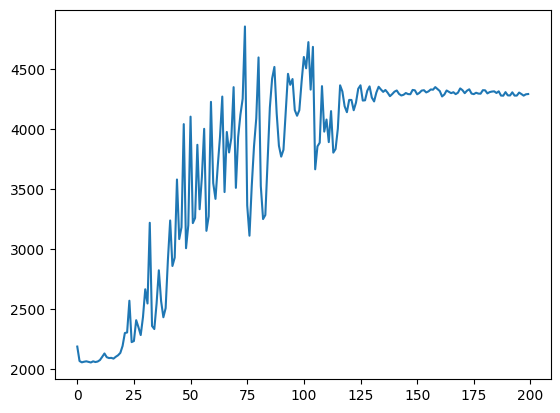

Minimum loss at epoch 6 being 2053.9


In [ ]:
torch.manual_seed(42)

# BUILDING MODEL
class NeuralNetworkModelComplex2(torch.nn.Module):
    def __init__(self):
      # 7 INPUT / 6x1024 HIDDEN / 1 OUTPUT
        super().__init__()
        self.hidden1 = torch.nn.Linear(7, 1024)
        self.hidden2 = torch.nn.Linear(1024, 1024)
        self.hidden3 = torch.nn.Linear(1024, 1024)
        self.hidden4 = torch.nn.Linear(1024, 1024)
        self.hidden5 = torch.nn.Linear(1024, 1024)
        self.hidden6 = torch.nn.Linear(1024, 1024)
        self.output = torch.nn.Linear(1024, 1)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.relu(self.hidden3(x))
        x = self.relu(self.hidden4(x))
        x = self.relu(self.hidden5(x))
        x = self.relu(self.hidden6(x))
        x = self.output(x)
        return x


# TRAIN-TEST SPLIT
train_size = int(len(df) * 0.8)

df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]

train_input = df_train[input_cols]
train_output = df_train[target_col]
test_input = df_test[input_cols]
test_output = df_test[target_col]

train_input_tensor = torch.tensor(train_input.to_numpy(), dtype=torch.float32)
train_output_tensor = torch.tensor(train_output.to_numpy(), dtype=torch.float32)
test_input_tensor = torch.tensor(test_input.to_numpy(), dtype=torch.float32)
test_output_tensor = torch.tensor(test_output.to_numpy(), dtype=torch.float32)

# INITIALIZING MODEL, LOSS FUNCTION AND OPTIMIZER
model = NeuralNetworkModelComplex2()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# STANDARDIZATION PARAMETERS
mu_target = scaler.mean_[-1]
sigma_target = scaler.scale_[-1]


### TRAINING
epochs = 200
losses = []
for epoch in range(epochs):

  model.train() # Sets train mode

  y_pred = model(train_input_tensor) # Test model on current params

  loss = loss_fn(train_output_tensor, y_pred) # Calculate loss function

  optimizer.zero_grad() # Resets gradient for the selected optimizer

  loss.backward() # Performs backpropagation

  optimizer.step() # Perform optimization

  model.eval() # Sets evaluation mode (test)

  with torch.inference_mode():
    # Calculate test loss for this epoch
    y_test_pred = model(test_input_tensor)
    loss = loss_fn(test_output_tensor, y_test_pred)
    loss = loss * sigma_target + mu_target
    losses.append(float(loss.detach().numpy()))

# PLOTS LOSSES OVER EVERY EPOCH
plt.plot(range(epochs), losses)
plt.show()

print(f"Minimum loss at epoch {losses.index(min(losses))} being {round(min(losses), 1)}")

Again, as the **minimum loss** is registered at the **6th epoch**, we will **re-train** the model to get the **maximum performance** like before

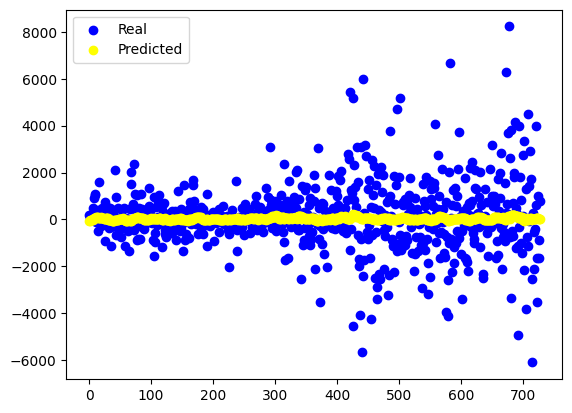

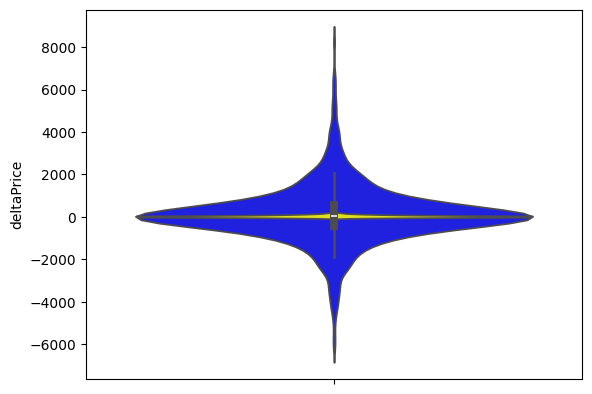

In [ ]:
torch.manual_seed(42)

# BUILDING MODEL
class NeuralNetworkModelComplex2(torch.nn.Module):
    def __init__(self):
      # 7 INPUT / 6x1024 HIDDEN / 1 OUTPUT
        super().__init__()
        self.hidden1 = torch.nn.Linear(7, 1024)
        self.hidden2 = torch.nn.Linear(1024, 1024)
        self.hidden3 = torch.nn.Linear(1024, 1024)
        self.hidden4 = torch.nn.Linear(1024, 1024)
        self.hidden5 = torch.nn.Linear(1024, 1024)
        self.hidden6 = torch.nn.Linear(1024, 1024)
        self.output = torch.nn.Linear(1024, 1)
        self.relu = torch.nn.ReLU()

    def forward(self, x):
        x = self.relu(self.hidden1(x))
        x = self.relu(self.hidden2(x))
        x = self.relu(self.hidden3(x))
        x = self.relu(self.hidden4(x))
        x = self.relu(self.hidden5(x))
        x = self.relu(self.hidden6(x))
        x = self.output(x)
        return x


# TRAIN-TEST SPLIT
train_size = int(len(df) * 0.8)

df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]

train_input = df_train[input_cols]
train_output = df_train[target_col]
test_input = df_test[input_cols]
test_output = df_test[target_col]

train_input_tensor = torch.tensor(train_input.to_numpy(), dtype=torch.float32)
train_output_tensor = torch.tensor(train_output.to_numpy(), dtype=torch.float32)
test_input_tensor = torch.tensor(test_input.to_numpy(), dtype=torch.float32)
test_output_tensor = torch.tensor(test_output.to_numpy(), dtype=torch.float32)

# INITIALIZING MODEL, LOSS FUNCTION AND OPTIMIZER
model = NeuralNetworkModelComplex()
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# STANDARDIZATION PARAMETERS
mu_target = scaler.mean_[-1]
sigma_target = scaler.scale_[-1]


### TRAINING
epochs = losses.index(min(losses))+1
for epoch in range(epochs):

  model.train() # Sets train mode

  y_pred = model(train_input_tensor) # Test model on current params

  loss = loss_fn(train_output_tensor, y_pred) # Calculate loss function

  optimizer.zero_grad() # Resets gradient for the selected optimizer

  loss.backward() # Performs backpropagation

  optimizer.step() # Perform optimization

  model.eval() # Sets evaluation mode (test)


# FINAL TESTING
y_pred_tens = model(test_input_tensor)
y_pred = y_pred_tens.detach().numpy()

# RE-CONVERTING FROM STANDARDIZED OUTPUTS
test_output = test_output * sigma_target + mu_target
y_pred = y_pred * sigma_target + mu_target

# CALCULATE LOSS
loss = loss_fn(test_output_tensor, y_pred_tens)
plt.scatter(range(len(test_output)), test_output, color="blue", label="Real")
plt.scatter(range(len(y_pred)), y_pred, color="#FFFF00", label="Predicted")
plt.legend()
plt.show()

# SHOW PREDICTION DENSITIES
import matplotlib
sns.violinplot(test_output.squeeze(), fill=True, color="blue", label="Real")
sns.violinplot(y_pred.squeeze(), fill=True, color="#FFFF00", label="Predicted")
plt.show()

models_losses.append(float(loss.detach().numpy()) * sigma_target + mu_target)
models_preds.append(y_pred.squeeze())

  With this, we can see that the **new model didn't** do better than the **previous**, as it also retuned a **slightly higher loss**, indicating that building **even more complex models won't probably help**, so we stop there and give our **conclusions**

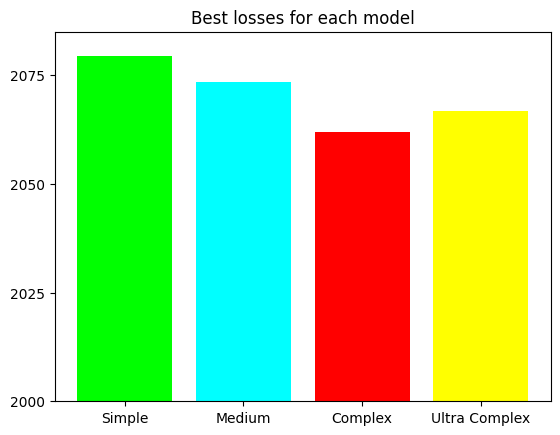

In [ ]:
# PLOTTING BARGRAPH WITH ALL THE MODELS LOSSES
plt.bar(["Simple", "Medium", "Complex", "Ultra Complex"], models_losses, color=["#00FF00", "#00FFFF", "#FF0000", "#FFFF00"])
plt.yticks([2000, 2025, 2050, 2075])
plt.ylim(2000, 2085)
plt.title("Best losses for each model")
plt.show()

We can see how **every model**, except for the last one, **lowered** the previous model's loss by a **fraction**, while still keeping it **very high**

This could be caused by the following problems:
1. **The dataset is too small** (only 10 years worth of time, less than 5k samples), making it difficult to train bigger complex models
2. **These features could not explain well price variations**, as only prices and volumes were taken as primary features
3. **There is an underlying random factor in daily prices**, impossible to predict

By taking the **best model so far (the Red one)**, we can see how its predictions are the **narrower ones**, advising how a **small prediction range**, centered on a value that **minimises squared loss** (as we used MSE loss) is the **best choice** in this situation

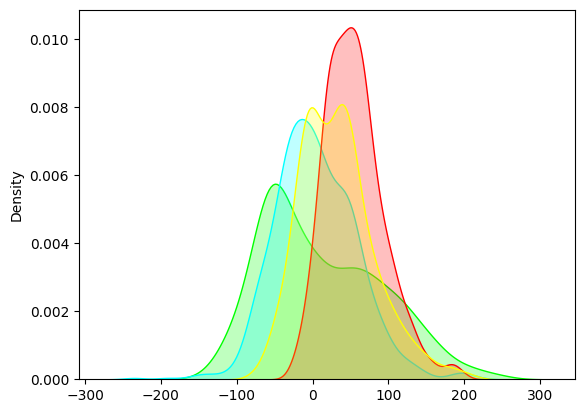

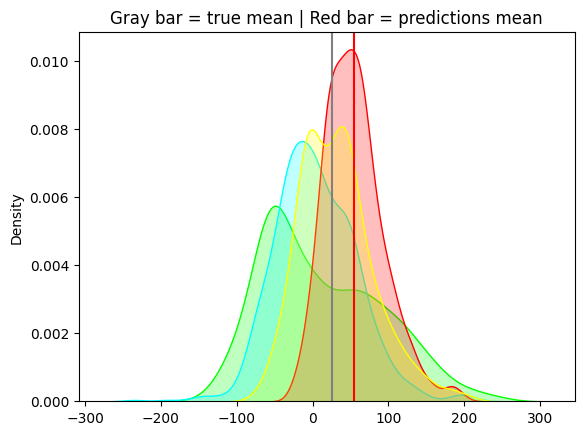


Mean deltaPrice value: 25.62$
Median Complex model prediction: 55.0$


In [ ]:
# STANDARDIZATION PARAMETERS
mu_target = scaler.mean_[-1]
sigma_target = scaler.scale_[-1]

mean_dpv = float(df["deltaPrice"].mean()) * sigma_target + mu_target
mean_complex = models_preds[2].mean()

sns.kdeplot(models_preds[0], fill=True, color="#00FF00")
sns.kdeplot(models_preds[1], fill=True, color="#00FFFF")
sns.kdeplot(models_preds[2], fill=True, color="#FF0000")
sns.kdeplot(models_preds[3], fill=True, color="#FFFF00")
plt.show()

sns.kdeplot(models_preds[0], fill=True, color="#00FF00")
sns.kdeplot(models_preds[1], fill=True, color="#00FFFF")
sns.kdeplot(models_preds[2], fill=True, color="#FF0000")
sns.kdeplot(models_preds[3], fill=True, color="#FFFF00")
plt.axvline(mean_complex, color="#FF0000")
plt.axvline(mean_dpv, color="gray")
plt.title("Gray bar = true mean | Red bar = predictions mean")
plt.show()


print(f"\nMean deltaPrice value: {round(mean_dpv, 2)}$")
print(f"Median Complex model prediction: {round(mean_complex, 2)}$")

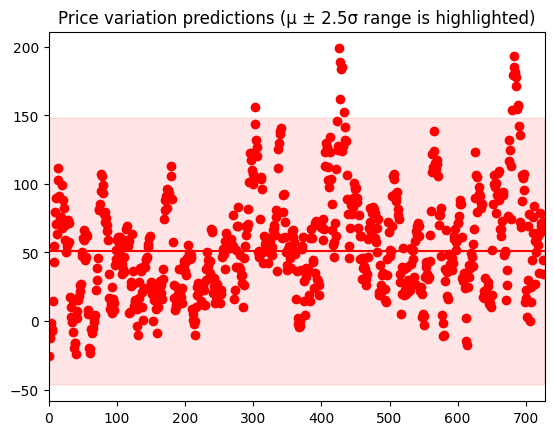

In [ ]:
# PLOTTING BEST MODEL'S PREDICTIONS
plt.scatter(range(len(models_preds[2])), models_preds[2], color="red", label="Predicted")
plt.axhline(np.median(models_preds[2]), color="red")
plt.fill_between(range(len(models_preds[2])), np.median(models_preds[2]) - 2.5*models_preds[2].std(), np.median(models_preds[2]) + 2.5*models_preds[2].std(), color="red", alpha=0.1)
plt.xlim(0, len(models_preds[2]))
plt.title("Price variation predictions (μ ± 2.5σ range is highlighted)")
plt.show()

Being its **predictions** in just a **200 dollar range**, considering **Bitcoin's latest prices** of over 100.000$, previous **true vs prediction graphs** and **high asset volatility**, this **narrow prediction range**, **possibly primed** from the **low prices** Bitcoin traded at in past years, it cannot be taken as an **acceptable result**

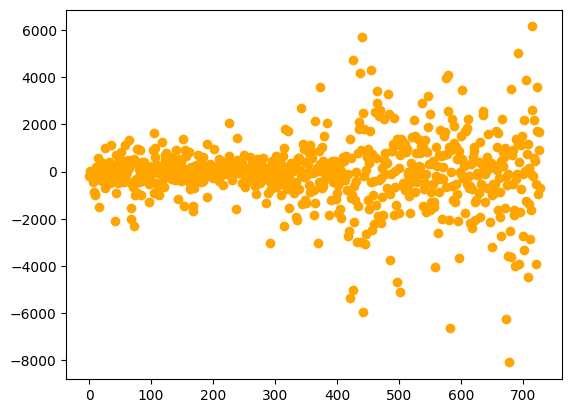

In [ ]:
# PLOTTING RESIDUALS
plt.scatter(range(len(models_preds[2])), models_preds[2] - np.array(test_output.values.squeeze().tolist()), color="orange", label="Predicted")
plt.show()

Also, by looking at a **residual plot**, it shows how **residuals** keep growing as the **expected output** does, showing that this behaviour is most probably the best to adopt with **such randomness**

# Conclusions

In **conclusion**, the quest of **building a predictive model** for B**itcoin prices**, starting from only past prices and volumes, **wasn't solved**

---

If we want a **better predictive model**, we could try **applying other techniques**, such as:
* **Limiting time range to the near future**, to only include relevant prices, while reducing the number of samples
* **Training different models for different periods** (seasonality differentiation, for example)
* **Using more input days to average randomness**, to try to get more useful past insights
* **Modeling more days of cumulative return instead of single daily returns**, with the effect of smoothening randomness, while giving a more general and less specific output as the number of grouped days increases

Future work on the same goal isn't precluded, so keep yourself updated with my [GitHub](https://github.com/freyflyy), [Hugging Face](https://huggingface.co/freyflyy) and [Linkedin](https://www.linkedin.com/in/francesco-scolz) for more projects like this

---

Sincerely, thanks for your time!

*Scolz F.*
